In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

# csv to parquet
    - 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능합니다.

pip install pyarrow  
pip install fastparquet

In [9]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [13]:
csv_to_parquet('../data/preprocessed_data/train.csv', 'train')
csv_to_parquet('../data/preprocessed_data/test.csv', 'test')

train Done.
test Done.


# 데이터 불러오기

In [80]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')

In [81]:
train.head(3)

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,2022-06-23,1,17,1,106,지방도,0,0,60.0,32400.0,...,3,제3교래교,33.427747,126.662612,0,제3교래교,33.427749,126.662335,0,52.0
1,2022-07-28,1,21,2,103,일반국도,0,0,60.0,0.0,...,0,광양사거리,33.500730,126.529107,1,KAL사거리,33.504811,126.526240,0,30.0
2,2021-10-10,4,7,2,103,일반국도,0,0,80.0,0.0,...,0,창고천교,33.279145,126.368598,0,상창육교,33.280072,126.362147,0,61.0


In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   base_date              object 
 1   day_of_week            int64  
 2   base_hour              int64  
 3   lane_count             int64  
 4   road_rating            int64  
 5   road_name              object 
 6   multi_linked           int64  
 7   connect_code           int64  
 8   maximum_speed_limit    float64
 9   weight_restricted      float64
 10  height_restricted      float64
 11  road_type              int64  
 12  start_node_name        object 
 13  start_latitude         float64
 14  start_longitude        float64
 15  start_turn_restricted  int64  
 16  end_node_name          object 
 17  end_latitude           float64
 18  end_longitude          float64
 19  end_turn_restricted    int64  
 20  target                 float64
dtypes: float64(8), int64(9), object(4)
memory usage: 753.2

# 데이터 전처리

## 문자열

In [85]:
str_col = ['road_name','start_node_name','end_node_name']

for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

## 날짜

In [86]:
train['base_date'] = pd.to_datetime(train['base_date'])

test['base_date'] = pd.to_datetime(test['base_date'])

In [87]:
train['base_year'] = train['base_date'].dt.year
train['base_month'] = train['base_date'].dt.month
train['base_day'] = train['base_date'].dt.day

test['base_year'] = test['base_date'].dt.year
test['base_month'] = test['base_date'].dt.month
test['base_day'] = test['base_date'].dt.day

In [88]:
train = train.drop(columns = 'base_date' , axis = 1)

test = test.drop(columns = 'base_date' , axis = 1)

# 시각화

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

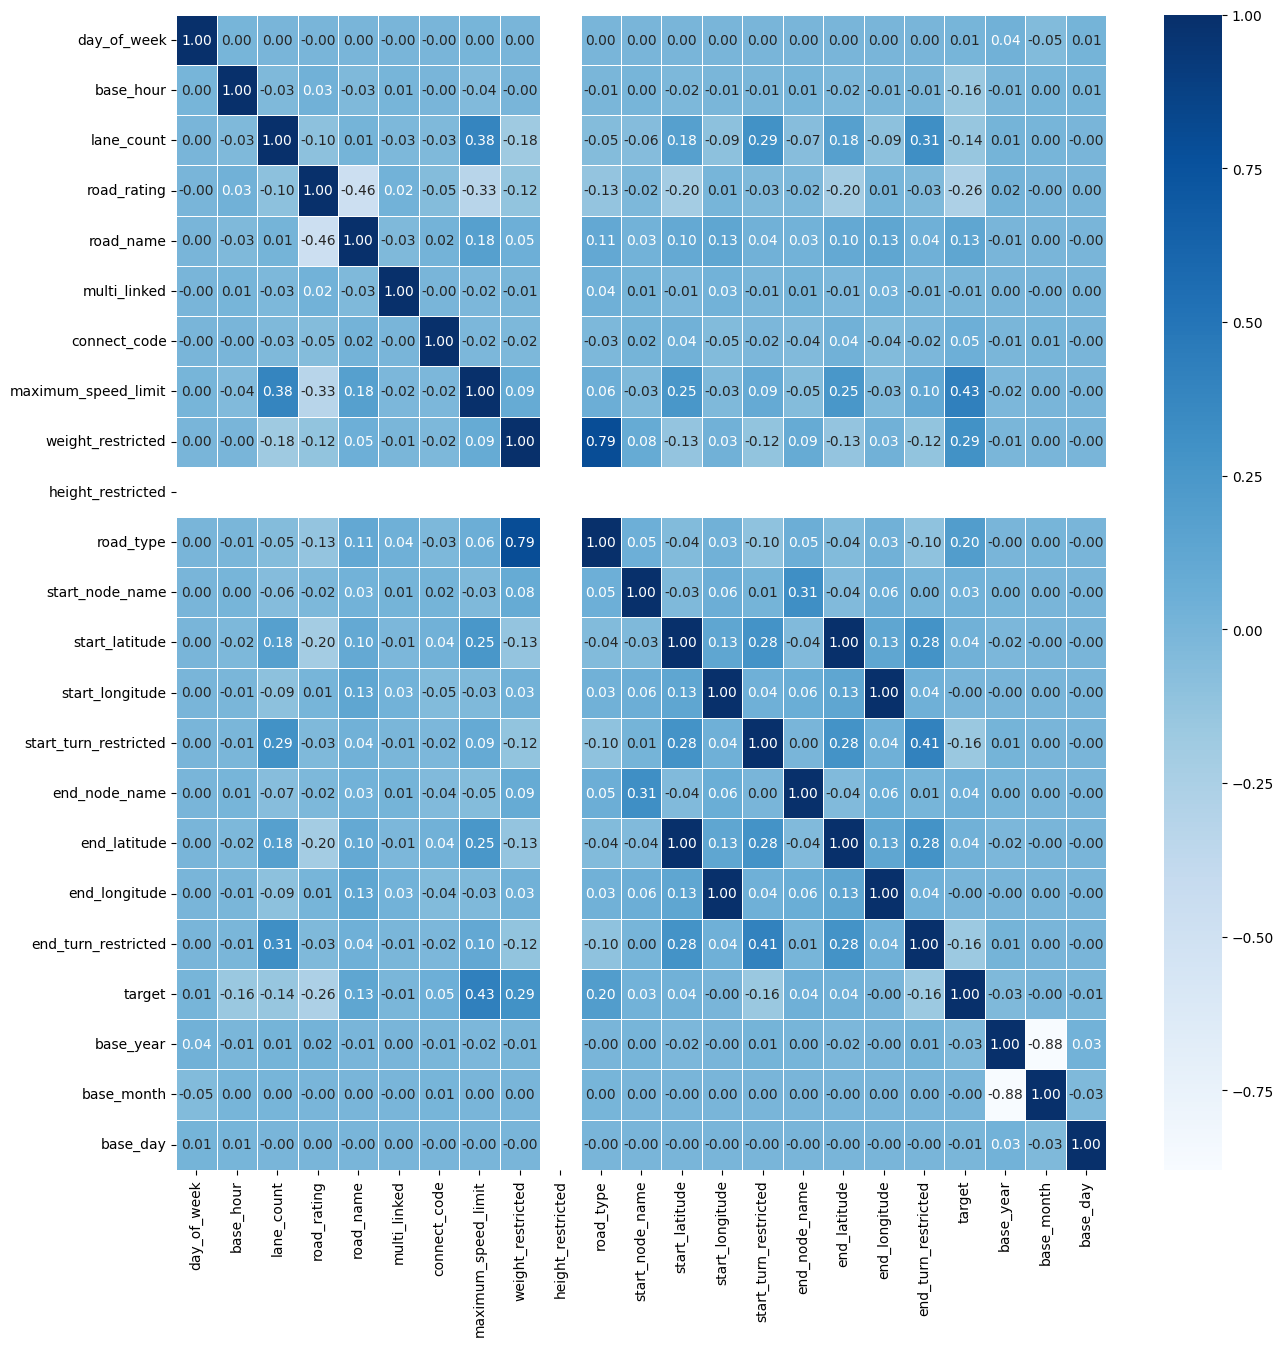

In [95]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

# 훈련

In [89]:
y_train = train['target']

x_train = train.drop(columns = 'target')

In [90]:
print(x_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 22)
(4701217,)
(291241, 22)


In [71]:
LR = lgb.LGBMRegressor(random_state=42).fit(x_train, y_train)

# 추론

In [72]:
pred = LR.predict(test)

# 제출

In [74]:
sample_submission = pd.read_csv('../data/initial_data/sample_submission.csv')

In [78]:
sample_submission['target'] = pred
sample_submission.to_csv("../data/submission/001.csv", index = False)

In [76]:
sample_submission

,id,target
0,TEST_000000,26.222770
1,TEST_000001,45.069756
2,TEST_000002,58.978876
3,TEST_000003,36.828078
4,TEST_000004,38.793189
...,...,...
291236,TEST_291236,48.283980
291237,TEST_291237,52.283216
291238,TEST_291238,23.079719
291239,TEST_291239,25.484650
